In [1]:
import pandas as pd
import numpy as np
import tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy.stats import boxcox
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
sales_of_company = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv", index_col='Month')
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv",  index_col='Month')
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv",  index_col='Month')
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv",  index_col='Month')
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv",  index_col='Week')
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv",  index_col='Date')

In [ ]:
data = pd.DataFrame(sales_of_company.copy())
for i in range(5, 20):
        data["lag_{}".format(i)] = data.Count.shift(i)
data

,Count,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
Month,,,,,,,,,,,,,,,,
1965-01,154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-02,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-03,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-04,49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1965-05,36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971-01,628,404.0,324.0,257.0,189.0,322.0,273.0,392.0,613.0,610.0,711.0,680.0,464.0,343.0,247.0,186.0
1971-02,308,677.0,404.0,324.0,257.0,189.0,322.0,273.0,392.0,613.0,610.0,711.0,680.0,464.0,343.0,247.0
1971-03,324,858.0,677.0,404.0,324.0,257.0,189.0,322.0,273.0,392.0,613.0,610.0,711.0,680.0,464.0,343.0


# Постоение рядов, оценка стационарности и выделение 2-х рядов для дальнейшей работы

In [ ]:
ts_dict = {'sales_of_company': sales_of_company, 
           'robberies_in_boston': robberies_in_boston,
           'airlines_passengers': airlines_passengers,
           'mean_monthly_temp': mean_monthly_temp,
           'dowjones_closing': dowjones_closing,
           'female_births': female_births}

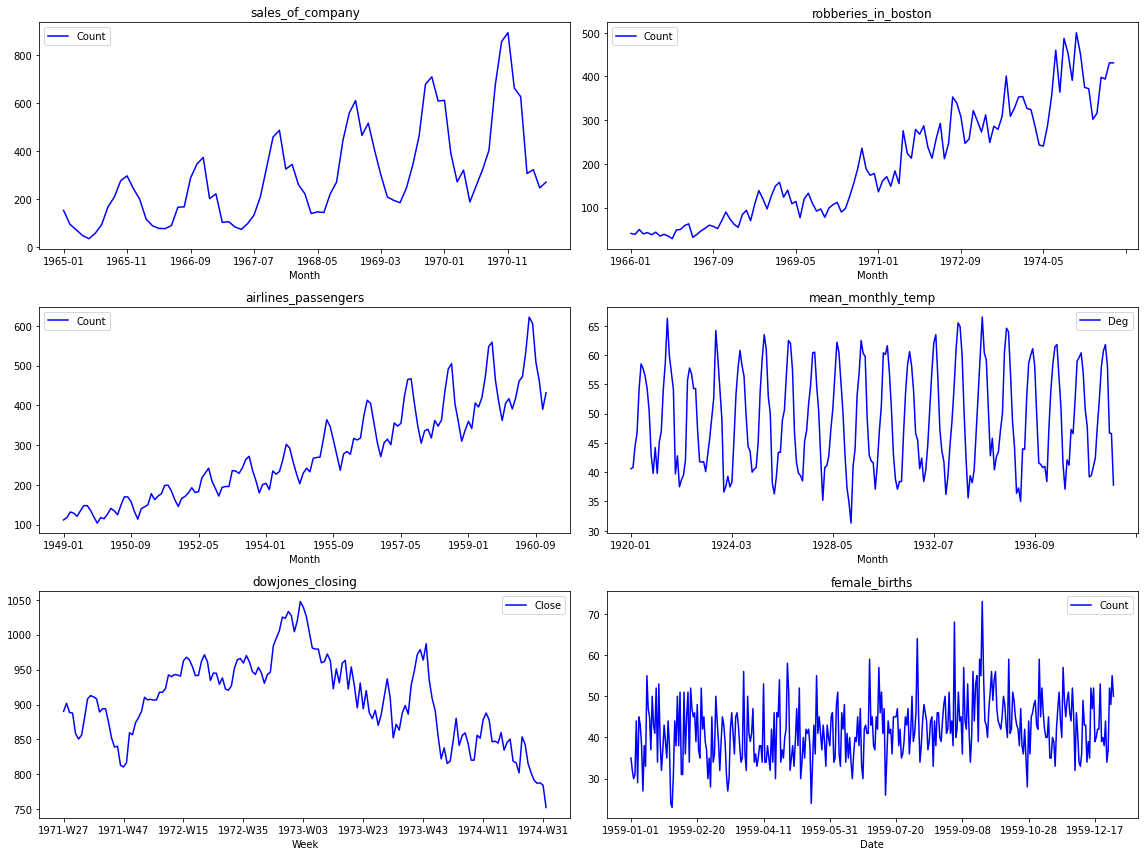

In [ ]:
plt.figure(figsize=(16, 12))
layout = (3, 2)
for i, key in enumerate(ts_dict.keys()):
    x = i % 2
    y = int((i - x) / 2)
        
    ts_ax = plt.subplot2grid(layout, (y, x))
    ts_dict[key].plot(ax=ts_ax, color='blue')
    ts_ax.set_title(key)
        
plt.tight_layout()

In [ ]:
def df_test(ts_dict):
  for key, value in ts_dict.items():
    p_value = adfuller(value, autolag='AIC')
    if p_value[1] > 0.05:
      print(f'Series: {key}, P value: {p_value[1]}, не отвергают гипотезу о нестационарности ряда')
    else:
      print(f'Series: {key}, P value: {p_value[1]}, отвергают гипотезу, ряд - стационарный')

In [ ]:
df_test(ts_dict)

Series: sales_of_company, P value: 0.9888894205170052, не отвергают гипотезу о нестационарности ряда
Series: robberies_in_boston, P value: 0.9942775638057231, не отвергают гипотезу о нестационарности ряда
Series: airlines_passengers, P value: 0.991880243437641, не отвергают гипотезу о нестационарности ряда
Series: mean_monthly_temp, P value: 0.016989030222608947, отвергают гипотезу, ряд - стационарный
Series: dowjones_closing, P value: 0.6224548515589733, не отвергают гипотезу о нестационарности ряда
Series: female_births, P value: 5.2434129901498554e-05, отвергают гипотезу, ряд - стационарный


In [3]:
ts_dict_new = {'sales_of_company': sales_of_company, 
               'female_births': female_births}

# ARIMA для обоих рядов


In [ ]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [ ]:
series = boxcox(ts_dict_new['sales_of_company']['Count'], 0)
series_1 = boxcox(ts_dict_new['female_births']['Count'], 0)

# sales_of_company

In [ ]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

aic: -33.21456 | order: (3, 1, 2)


In [ ]:
arima = smt.ARIMA(series, order=(3, 1, 2)).fit(method='mle', trend='nc')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
p_value = adfuller(arima.resid, autolag='AIC')
if p_value[1] > 0.05:
  print(f'P value: {p_value[1]}, не отвергают гипотезу о нестационарности ряда')
else:
  print(f'P value: {p_value[1]}, отвергают гипотезу, ряд - стационарный')

P value: 2.375317986554071e-15, отвергают гипотезу, ряд - стационарный


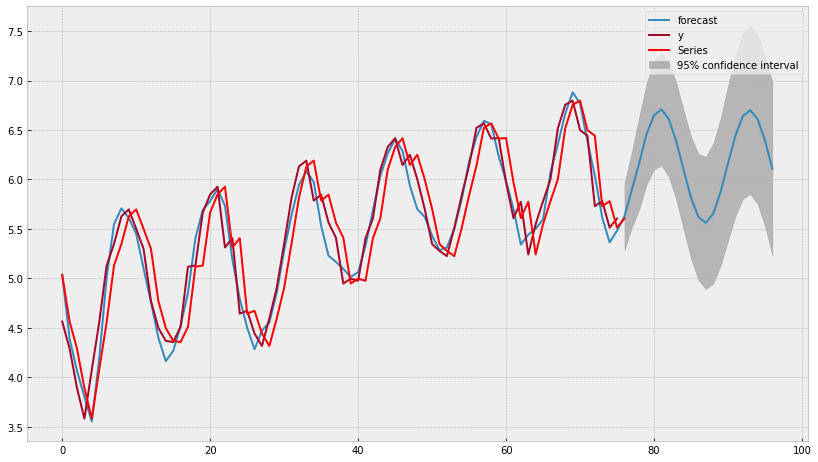

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    arima.plot_predict(1, len(series)+20, ax=ax)
    plt.plot(series, color='red', label='Series')
    plt.legend()
    plt.show()

# female_births

In [ ]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = smt.ARIMA(series_1, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

aic: -266.66790 | order: (2, 1, 4)


In [ ]:
arima_1 = smt.ARIMA(series_1, order=(2, 1, 4)).fit(method='mle', trend='nc')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
p_value = adfuller(arima_1.resid, autolag='AIC')
if p_value[1] > 0.05:
  print(f'P value: {p_value[1]}, не отвергают гипотезу о нестационарности ряда')
else:
  print(f'P value: {p_value[1]}, отвергают гипотезу, ряд - стационарный')

P value: 0.0, отвергают гипотезу, ряд - стационарный


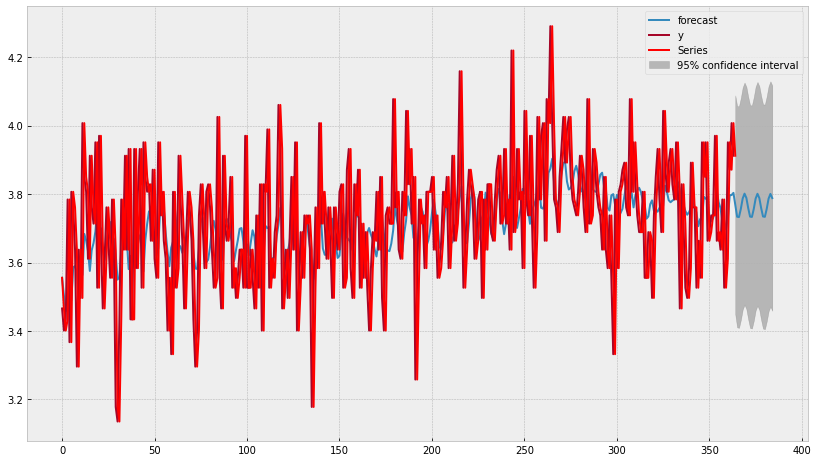

In [ ]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    arima_1.plot_predict(1, len(series_1)+20, ax=ax)
    plt.plot(series_1, color='red', label='Series')
    plt.legend()
    plt.show()

# NN LSTM

In [4]:
data = ts_dict_new['female_births'].copy()
for ts in range(5,20):
  data[f'Lag_{ts}'] = ts_dict_new['female_births'].shift(ts)
data

,Count,Lag_5,Lag_6,Lag_7,Lag_8,Lag_9,Lag_10,Lag_11,Lag_12,Lag_13,Lag_14,Lag_15,Lag_16,Lag_17,Lag_18,Lag_19
Date,,,,,,,,,,,,,,,,
1959-01-01,35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-01-02,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-01-03,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-01-04,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-01-05,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959-12-27,37,39.0,53.0,42.0,42.0,40.0,39.0,52.0,47.0,52.0,35.0,39.0,34.0,43.0,43.0,49.0
1959-12-28,52,40.0,39.0,53.0,42.0,42.0,40.0,39.0,52.0,47.0,52.0,35.0,39.0,34.0,43.0,43.0
1959-12-29,48,38.0,40.0,39.0,53.0,42.0,42.0,40.0,39.0,52.0,47.0,52.0,35.0,39.0,34.0,43.0


In [5]:
data = data.dropna().reset_index().drop(['Date'], axis=1)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,1:], data.iloc[:,:1], test_size=0.15, random_state=42)

In [8]:
X_train.shape

(294, 15)

In [9]:
scaler = StandardScaler()

In [10]:
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [11]:
import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, TimeDistributed, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D

In [12]:
X_train_std = X_train_std.reshape((X_train_std.shape[0], X_train_std.shape[1], 1))
X_test_std = X_test_std.reshape((X_test_std.shape[0], X_test_std.shape[1], 1))

In [13]:
n_timesteps, n_features, n_outputs = X_train_std.shape[0], X_train_std.shape[1], y_train.shape[1]
model = Sequential()
model.add(Bidirectional(LSTM(100, activation='relu', return_sequences=True), input_shape=(X_train_std.shape[1], X_test_std.shape[2])))
model.add(LSTM(100, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(n_outputs))
model.compile(loss='mse', optimizer=keras.optimizers.Adam(0.0001))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 15, 200)          81600     
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 100)               120400    
                                                                 
 dense (Dense)               (None, 15)                1515      
                                                                 
 dense_1 (Dense)             (None, 1)                 16        
                                                                 
Total params: 203,531
Trainable params: 203,531
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
 
BATCH_SIZE = 256
EPOCHS = 100
 
history = model.fit(X_train_std,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.2,
                    verbose=1)

Epoch 1/100
1/1 [==============================] - 7s 7s/step - loss: 1844.3395 - mse: 1844.3395 - val_loss: 1814.7424 - val_mse: 1814.7424
Epoch 2/100
1/1 [==============================] - 0s 250ms/step - loss: 1839.9160 - mse: 1839.9160 - val_loss: 1812.4469 - val_mse: 1812.4469
Epoch 3/100
1/1 [==============================] - 0s 298ms/step - loss: 1837.6837 - mse: 1837.6837 - val_loss: 1810.2487 - val_mse: 1810.2487
Epoch 4/100
1/1 [==============================] - 0s 175ms/step - loss: 1835.5637 - mse: 1835.5637 - val_loss: 1807.5814 - val_mse: 1807.5814
Epoch 5/100
1/1 [==============================] - 0s 149ms/step - loss: 1832.9822 - mse: 1832.9822 - val_loss: 1804.5356 - val_mse: 1804.5356
Epoch 6/100
1/1 [==============================] - 0s 165ms/step - loss: 1830.0347 - mse: 1830.0347 - val_loss: 1800.9984 - val_mse: 1800.9984
Epoch 7/100
1/1 [==============================] - 0s 159ms/step - loss: 1826.6030 - mse: 1826.6030 - val_loss: 1796.7416 - val_mse: 1796.7416
Ep

In [15]:
y_pred = model.predict(X_test_std, verbose=1)

2/2 [==============================] - 1s 10ms/step


In [16]:
y_test['pred'] = y_pred.squeeze().tolist()

In [17]:
y_test.drop(['Count'], axis=1, inplace=True)

In [18]:
y_test.rename(columns={'pred': 'Count'}, inplace=True)

In [19]:
series_pred = pd.concat([y_train, y_test])
series_pred.reset_index(drop=True, inplace=True)

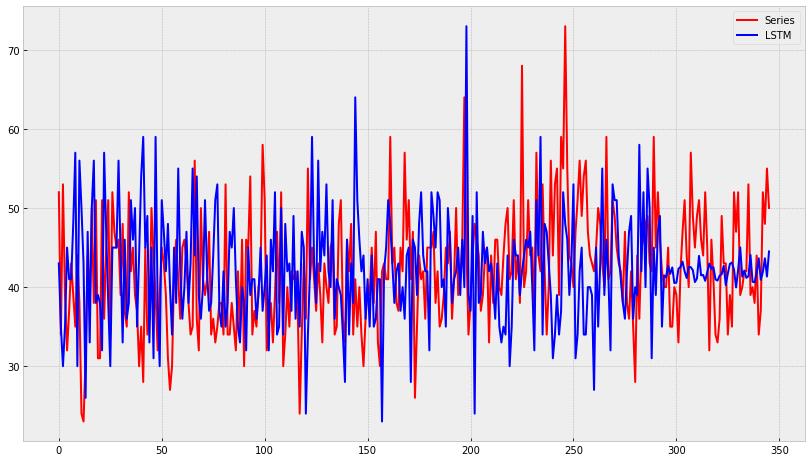

In [20]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    plt.plot(data['Count'], color='red', label='Series')
    plt.plot(series_pred['Count'], color='blue', label='LSTM')
    plt.legend()
    plt.show()